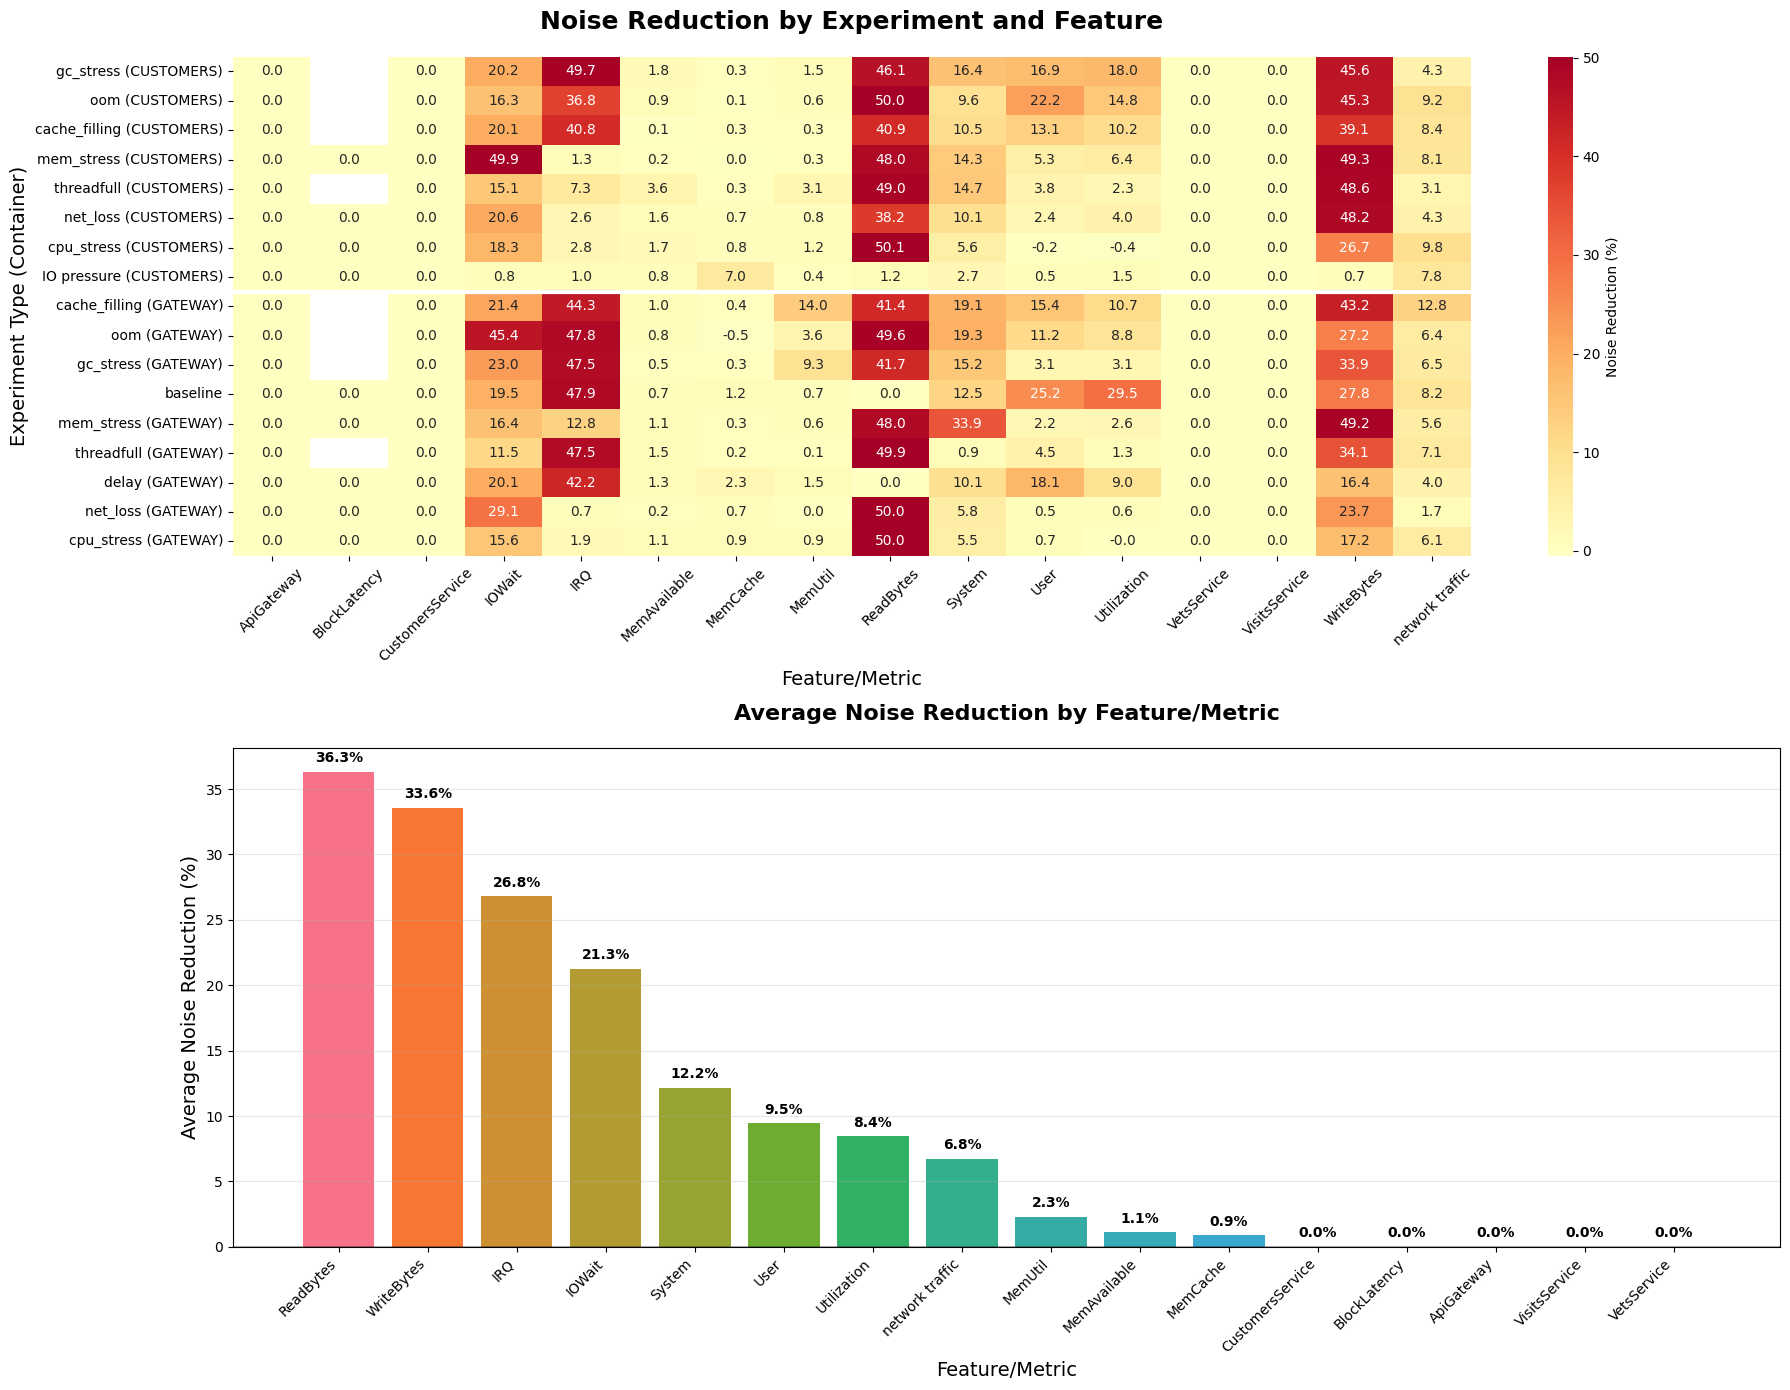

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np

data_dir = "."  

def load_all_tuna_data(directory):
    """Load all TUNA CSV files from directory"""
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    all_data = []
    
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path).replace('.csv', '')
            df['source_file'] = filename
            all_data.append(df)
        except Exception as e:
            pass
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return None

df_all = load_all_tuna_data(data_dir)

if df_all is not None:
    df_clean = df_all.dropna(subset=['experiment_name', 'metric', 'noise_reduction_pct'])
    df_clean['noise_reduction_pct'] = pd.to_numeric(df_clean['noise_reduction_pct'], errors='coerce')
    
    def extract_container(filename):
        if 'customers' in filename.lower():
            return 'customers'
        elif 'gateway' in filename.lower():
            return 'gateway'
        else:
            return 'unknown'
    
    df_clean['container'] = df_clean['source_file'].apply(extract_container)
    df_clean = df_clean[df_clean['container'] != 'unknown']
    df_clean = df_clean[~((df_clean['experiment_name'].str.contains('baseline', case=False)) & 
                          (df_clean['container'] == 'customers'))]
    
    df_clean['metric'] = df_clean['metric'].replace('SRTT', 'network traffic')
    df_clean['experiment_container'] = df_clean['experiment_name'] + ' (' + df_clean['container'].str.upper() + ')'
    
    df_clean.loc[df_clean['experiment_container'].str.contains('baseline.*GATEWAY', case=False), 'experiment_container'] = 'baseline'
    
    pivot_data_combined = df_clean.pivot_table(
        values='noise_reduction_pct', 
        index='experiment_container', 
        columns='metric', 
        aggfunc='mean'
    )
    
    customers_experiments = [idx for idx in pivot_data_combined.index if 'CUSTOMERS' in idx]
    gateway_experiments = [idx for idx in pivot_data_combined.index if 'GATEWAY' in idx or idx == 'baseline']
    
    customers_avg = pivot_data_combined.loc[customers_experiments].mean(axis=1).sort_values(ascending=False)
    gateway_avg = pivot_data_combined.loc[gateway_experiments].mean(axis=1).sort_values(ascending=False)
    
    ordered_index = list(customers_avg.index) + list(gateway_avg.index)
    pivot_data_ordered = pivot_data_combined.reindex(ordered_index)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
    
    sns.heatmap(pivot_data_ordered, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0, 
                ax=ax1,
                cbar_kws={'label': 'Noise Reduction (%)'})
    
    ax1.set_title('Noise Reduction by Experiment and Feature', 
                 fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Feature/Metric', fontsize=14)
    ax1.set_ylabel('Experiment Type (Container)', fontsize=14)
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)  # Make y-axis labels horizontal
    
    customers_count = len(customers_experiments)
    if customers_count > 0:
        ax1.axhline(y=customers_count, color='white', linewidth=3)
    
    feature_performance = df_clean.groupby('metric')['noise_reduction_pct'].mean().sort_values(ascending=False)
    
    bars = ax2.bar(range(len(feature_performance)), feature_performance.values, 
                   color=sns.color_palette("husl", len(feature_performance)))
    
    ax2.set_title('Average Noise Reduction by Feature/Metric', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Feature/Metric', fontsize=14)
    ax2.set_ylabel('Average Noise Reduction (%)', fontsize=14)
    ax2.set_xticks(range(len(feature_performance)))
    ax2.set_xticklabels(feature_performance.index, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, feature_performance.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

else:
    pass

# remember the tcp container for customers and gatway jvm apigateway hack!!

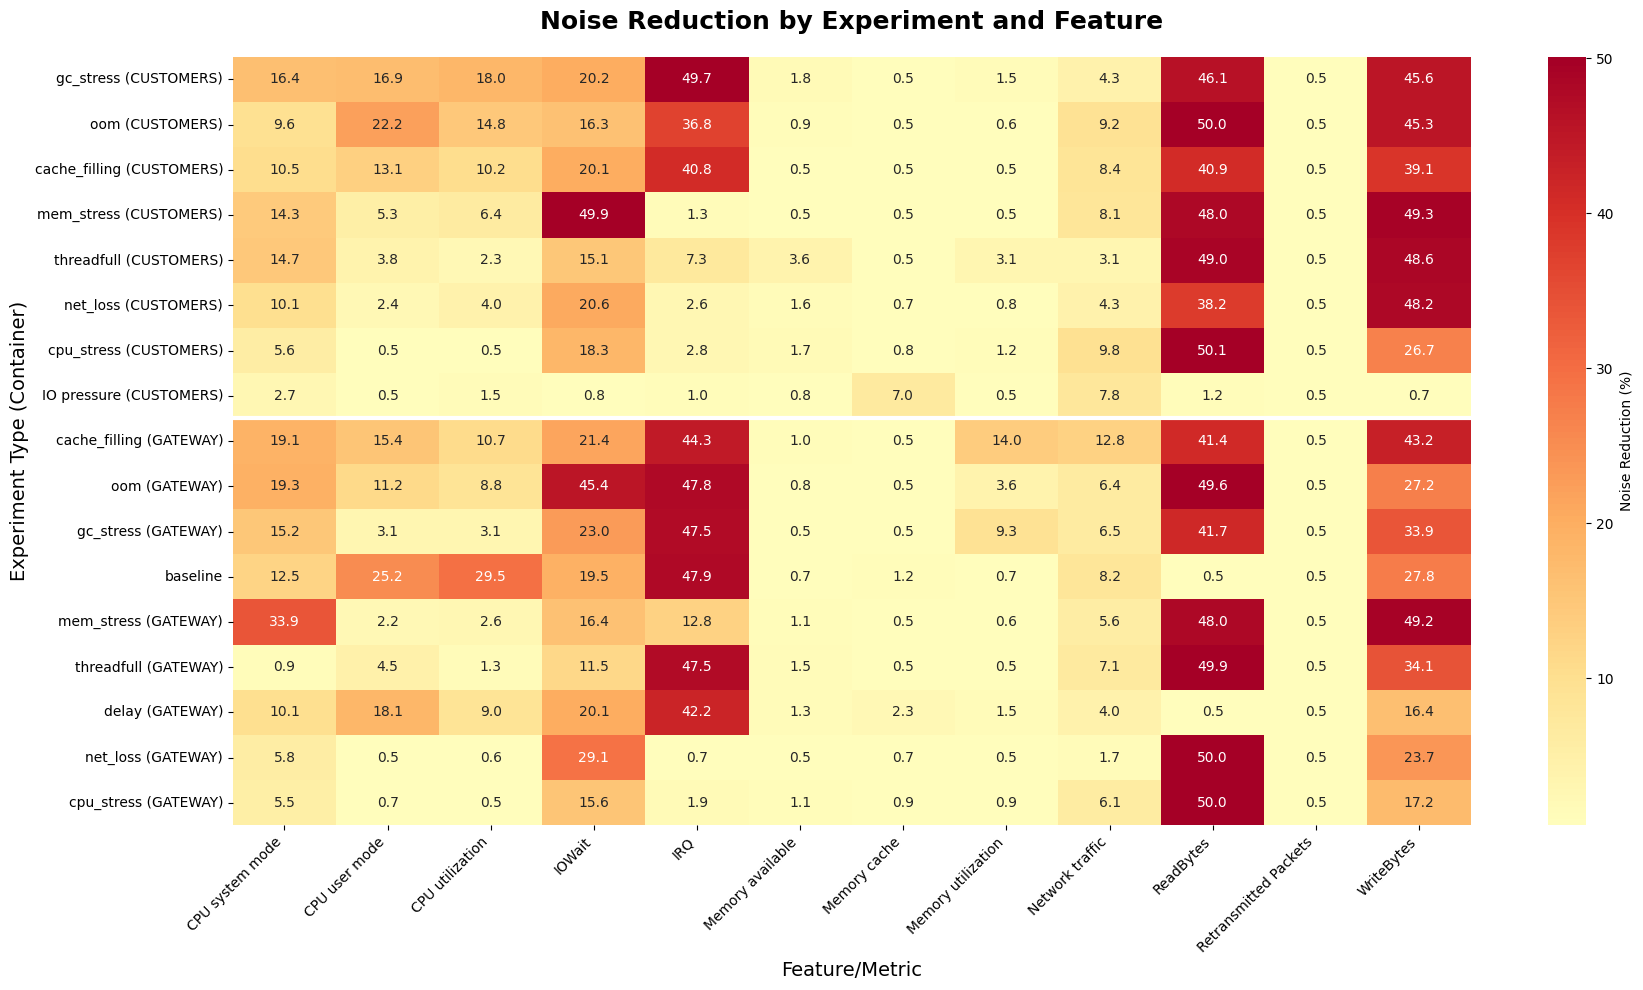

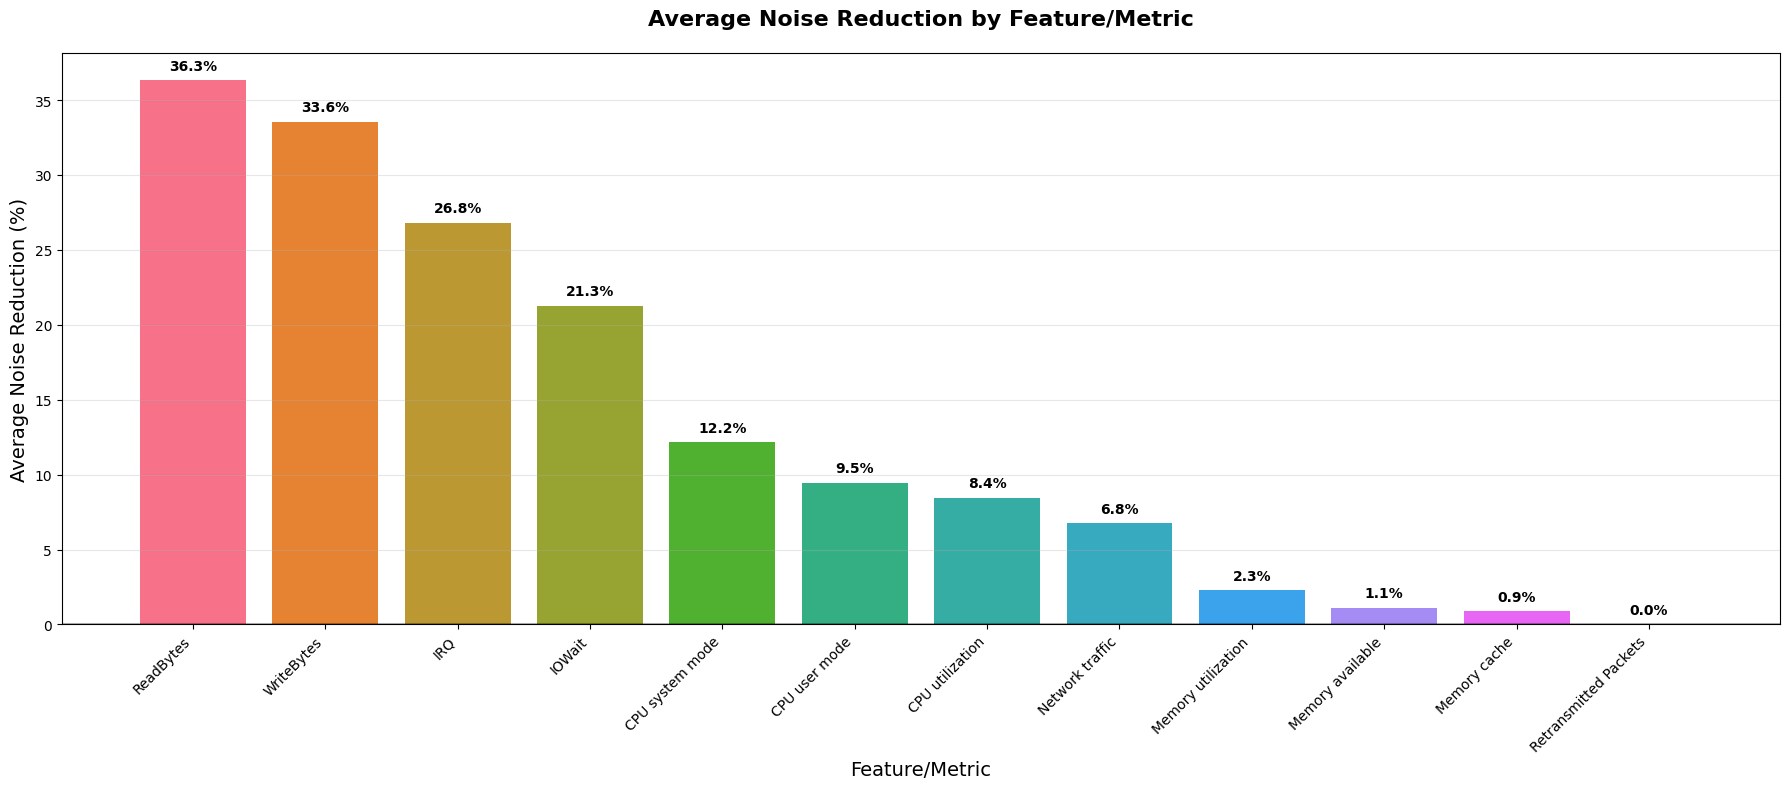

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np

data_dir = "."

def load_all_tuna_data(directory):
    """Load all TUNA CSV files from directory"""
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    all_data = []
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path).replace('.csv', '')
            df['source_file'] = filename
            all_data.append(df)
        except Exception:
            pass
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return None

df_all = load_all_tuna_data(data_dir)

if df_all is not None:
    df_clean = df_all.dropna(subset=['experiment_name', 'metric', 'noise_reduction_pct']).copy()
    df_clean['noise_reduction_pct'] = pd.to_numeric(df_clean['noise_reduction_pct'], errors='coerce')

    # Normalizzazione per matching robusto
    def normalize_key(x: str) -> str:
        return ''.join(ch for ch in str(x) if ch.isalnum()).lower()

    normalized_metric = df_clean['metric'].apply(normalize_key)

    # Aggrega questi servizi in "Retransmitted Packets" e forza noise_reduction a 0.0 (TUNA non applicato)
    service_patterns = {'customerservice', 'apigateway', 'visitsservice', 'vetsservice'}
    mask_services = normalized_metric.isin(service_patterns)
    df_clean.loc[mask_services, 'metric'] = 'Retransmitted Packets'
    df_clean.loc[mask_services, 'noise_reduction_pct'] = 0.0

    # Drop metriche indesiderate (BlockLatency, BlockCountLatency, ecc.)
    drop_patterns = {'blockcountlatency', 'blocklatency', 'customersservice'}
    mask_drop = normalized_metric.isin(drop_patterns)
    df_clean = df_clean[~mask_drop].copy()

    # Estrai container dal nome file
    def extract_container(filename):
        if 'customers' in filename.lower():
            return 'customers'
        elif 'gateway' in filename.lower():
            return 'gateway'
        else:
            return 'unknown'

    df_clean['container'] = df_clean['source_file'].apply(extract_container)
    df_clean = df_clean[df_clean['container'] != 'unknown']

    # Rimuovi baseline dei customers
    df_clean = df_clean[~((df_clean['experiment_name'].str.contains('baseline', case=False)) &
                          (df_clean['container'] == 'customers'))]

    # Rinomina per label più chiare
    def pretty_metric_name(m):
        k = normalize_key(m)
        mapping = {
            'memavailable': 'Memory available',
            'memcache': 'Memory cache',
            'memutil': 'Memory utilization',
            'system': 'CPU system mode',
            'user': 'CPU user mode',
            'utilization': 'CPU utilization',
            'srtt': 'Network traffic'
        }
        if m == 'SRTT':
            return 'Network traffic'
        return mapping.get(k, m)

    df_clean['metric'] = df_clean['metric'].apply(pretty_metric_name)

    # Colonna combinata esperimento + container
    df_clean['experiment_container'] = df_clean['experiment_name'] + ' (' + df_clean['container'].str.upper() + ')'
    # Normalizza baseline per gateway
    df_clean.loc[df_clean['experiment_container'].str.contains('baseline.*GATEWAY', case=False),
                 'experiment_container'] = 'baseline'

    # -------------------------
    # Plot 1: Heatmap separata
    # -------------------------
    pivot_data_combined = df_clean.pivot_table(
        values='noise_reduction_pct',
        index='experiment_container',
        columns='metric',
        aggfunc='mean'
    )

    # sostituisci valori negativi con 0.5
    pivot_data_combined = pivot_data_combined.clip(lower=0.5)

    # Ordina righe: prima customers poi gateway/baseline
    customers_experiments = [idx for idx in pivot_data_combined.index if 'CUSTOMERS' in idx]
    gateway_experiments = [idx for idx in pivot_data_combined.index if 'GATEWAY' in idx or idx == 'baseline']

    customers_avg = (pivot_data_combined.loc[customers_experiments].mean(axis=1).sort_values(ascending=False)
                     if customers_experiments else pd.Series(dtype=float))
    gateway_avg = (pivot_data_combined.loc[gateway_experiments].mean(axis=1).sort_values(ascending=False)
                   if gateway_experiments else pd.Series(dtype=float))

    ordered_index = list(customers_avg.index) + list(gateway_avg.index)
    pivot_data_ordered = pivot_data_combined.reindex(ordered_index)

    plt.figure(figsize=(18, 10))
    sns.heatmap(pivot_data_ordered,
                annot=True,
                fmt='.1f',
                cmap='RdYlBu_r',
                center=0,
                cbar_kws={'label': 'Noise Reduction (%)'})
    plt.title('Noise Reduction by Experiment and Feature', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Feature/Metric', fontsize=14)
    plt.ylabel('Experiment Type (Container)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    customers_count = len(customers_experiments)
    if customers_count > 0:
        plt.axhline(y=customers_count, color='white', linewidth=3)
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Plot 2: Bar chart separato (con negativi visibili)
    # -------------------------
    feature_performance = (df_clean.groupby('metric')['noise_reduction_pct']
                           .mean()
                           .sort_values(ascending=False))

    plt.figure(figsize=(18, 8))
    bars = plt.bar(range(len(feature_performance)), feature_performance.values,
                   color=sns.color_palette("husl", len(feature_performance)))
    plt.title('Average Noise Reduction by Feature/Metric', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Feature/Metric', fontsize=14)
    plt.ylabel('Average Noise Reduction (%)', fontsize=14)
    plt.xticks(range(len(feature_performance)), feature_performance.index, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # etichette valori sulle barre
    for bar, value in zip(bars, feature_performance.values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                 f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                 fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()

else:
    print("Nessun CSV trovato o struttura dati non valida.")
